In [1]:
# This cell is tagged for removal

import os
import math
import pickle
from glob import glob

import numpy as np
import pandas as pd
from IPython import display as idisplay

from sklearn.metrics import r2_score

import aliases # important this goes first to configure PATH

from everest.window import Canvas, plot, raster, DataChannel as Channel, get_cmap
from everest.window.colourmaps import *
from everest.window import image, imop

from referencing import search
from myst_nb import glue
from analysis import isovisc, arrhenius, utilities, common, analysis, visualisation
%matplotlib inline

osjoin = os.path.join

import warnings

warnings.filterwarnings("ignore",category=UserWarning)

# Isoviscous rheology with internal and mixed heating

On Earth and other planets, the geothermal flux is not solely driven by basal heating from the core: there is a substantial, variable, and transient contribution from radioactive decay as well {cite}`Daly1980-xl`. In mantle convection studies this is dubbed 'internal heating', and a system driven by both basal and internal heating is said to be 'mixed-heating'.

The ratio of internal heat production to surface heat flux inside a planet is called the *Urey* ratio $Ur$  {cite}`Urey1955-zs`. Values less than one signify that a planet on the whole is cooling, while values greater than one represent global interior warming. To avoid projecting unreasonable global temperatures into Earth's past, it was originally calculated that, for a *beta* exponent of $1/3$, the *Urey* number must be greater than $\sim0.7$ {cite}`Christensen1985-bu`. This assumption was forced into revision when it transpired that the radiogenic inventory of bulk mantle materials is far too low to support such a high radiogenic fraction {cite}`Jochum1983-dn`. Direct evidence from geoneutrinos now suggests that the *Urey* ratio must be around $0.5$ {cite}`Gando2011-sh`, and further argues that heat production is non-uniform throughout the mantle {cite}`Huang2013-eu`. Thermal histories that honour these facts have proved very difficult to construct {cite}`Korenaga2003-oy,Korenaga2008-js,Mareschal2012-ie,Dye2012-cx,Jaupart2015-un,Korenaga2017-an`.

Analytically, the addition of internal heating introduces many complications. Most significantly, the temperature scale is no longer an independent variable, but a natural one emerging from the dynamic balance of heat production and heat transport. This dependency invalidates the derivation of $Ra$ previously provided, and unfortunately, no obvious or unambiguous alternative scaling is known {cite}`Schubert2001-ea,Moore2008-je,Korenaga2017-an`.

## Internal heating

In [2]:
with open(osjoin(aliases.storagedir, 'condh.pkl'), mode = 'rb') as file:
    conddata = pickle.loads(file.read())
condgeotherms, condavts, condhs = (conddata[key] for key in ('geotherms', 'avts', 'hs'))

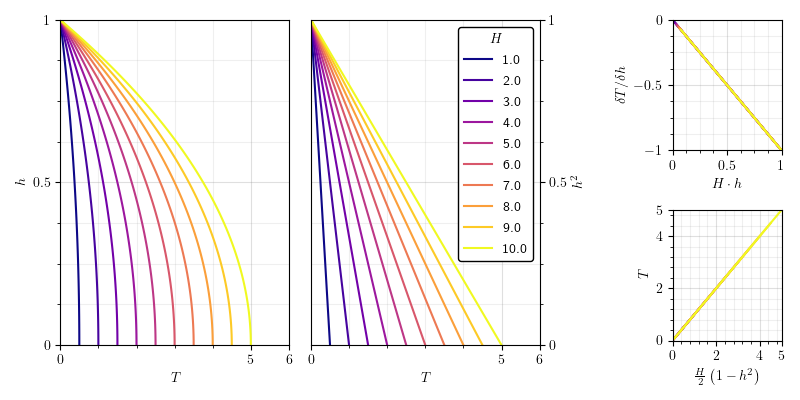

In [12]:
canvas1 = Canvas(shape = (1, 2), size = (6, 4))

ax1 = canvas1.make_ax((0, 0))
ax2 = canvas1.make_ax((0, 1))

for H, T in zip(condhs, condgeotherms):

    h = np.linspace(0, 1, len(T))
    c = cmap(H, condhs, style = 'plasma')

    ax1.line(
        Tchan := Channel(T, label = 'T', lims = (None, 6.), capped = (True, True)),
        Channel(h, label = 'h'),
        c = c,
        )

    ax2.line(
        Tchan,
        Channel(h**2., label = r"h^{2}", capped = (True, True)),
        c = c,
        )

ax2.props.edges.y.swap()

ax2.props.legend.set_handles_labels(
    (row[0] for row in ax1.collections),
    (str(round(H, 1)) for H in condhs),
    )
ax2.props.legend.title.text = 'H'
ax2.props.legend.title.visible = True
# ax2.props.legend.mplprops['bbox_to_anchor'] = (1.75, 0.85)
# ax1.props.legend.mplprops['ncol'] = 2
ax2.props.legend.frame.colour = 'black'
ax2.props.legend.frame.visible = True

canvas2 = Canvas(shape = (2, 1), size = (2, 4))
ax1 = canvas2.make_ax((0, 0))
ax2 = canvas2.make_ax((1, 0))

for H, T in zip(condhs, condgeotherms):
    h = np.linspace(0, 1, len(T))
    c = cmap(H, condhs, style = 'plasma')
    y, x = analysis.derivative(T, h)
    ax1.line(
        Channel(x * H, label = r"H \cdot h", lims = (0, 1), capped = (True, True)),
        Channel(y, label = r"\delta T / \delta h", lims = (-1, 0), capped = (True, True)),
        c = c,
        )
    y = T
    x = H / 2 * (1 - h**2)
    ax2.line(
        Channel(x, label = r"\frac{H}{2} \left( 1 - h^2 \right)", lims = (0, 5), capped = (True, True)),
        Channel(y, label = "T", lims = (0, 5), capped = (True, True)),
        c = c,
        )

fig = imop.hstack(canvas1, canvas2)

glue("isocondh", fig, display = False)

fig

```{glue:figure} isocondh
:figwidth: 600px
:name: "isocondh"

Summary of the scaling behaviours of isoviscous conduction for varying internal heating parameter $H$. Temperature goes linearly as a function of dimensionless height from the base of the mantle, $h^2$.
```

To provide some bounds on the expected behaviour of a mixed-heating model, it is helpful to review the effects of purely internal heating. Without the ability to arbitrarily specify a temperature scale, it is natural to use that which arises from pure conduction. Under a scenario of pure internal heating, the conductive geotherm is no longer linear, but scales with length squared {cite}`Turcotte2014-by` {numref}`isocondh`:

$$ \begin{align*}
{{T(h)}_{c}}^{'} &= H\cdot h \\
\therefore {T(h)}_{c} &= \frac{H}{2} \left( 1 - h^2 \right)
\end{align*} $$

Where $H$ is the per-mass heating rate and $h$ is the dimensionless height from the base of the mantle. The maximum mantle temperature possible for a given value of $H$ is thus $H/2$. Because, at the outer boundary, the thermal flux is exactly $H$ (or, technically, $H \cdot \rho$ if dimensionalised), $H$ here is identical to the 'conductive *Nusselt* number', ${Nu}_{c}$.

Having obtained the conductive geotherm, we can select a nominal temperature scale:

$$
{\Delta T}_H = \frac{\rho H b^2}{k}
$$

Where $k$ is the conductivity, $\rho$ is the density, $H$ is the per-mass heating rate, and $b$ is the characteristic spatial length. The temperature scale allows an 'internally heated *Rayleigh* number' ${Ra}_H$ to be defined {cite}`Roberts1967-aq`:

$$ \begin{align*}
{Ra}_H &= {Ra}_B \cdot {\Delta T}_H \\
&= \frac{\alpha g \rho H b^5}{k \kappa \nu}
\end{align*} $$

Where ${Ra}_B$ is the *Rayleigh* number derived for basal heating, introducing the parameters of thermal expansivity $\alpha$, gravity $g$, thermal diffusivity $\kappa$, and momentum diffusivity $\nu$ {cite}`Turcotte2014-by`. As in the basally-heated case, there exists for this number a critical value ${{Ra}_{H}}_{cr}$ which divides the purely conductive regime from the convecting regime {cite}`Roberts1967-aq`:

$$
{{Ra}_{H}}_{cr} \approx 868
$$

Usually we would be interested in deriving some scaling for the *Nusselt* number with respect to ${Ra}_H$. In this case, however, $Nu$ must always equal one. This follows because there are no other sources or sinks in the model except for $H$, which must be radiated in full from the upper boundary whether the interior is convecting or not. Rather than serving to augment the surface flux, convection in a purely internally-heated system only functions to smooth out interior temperatures. To describe this, we must choose a represenative internal temperature $T_{i}$, which should reflect a typical temperature in those regions where advection dominates {cite}`Solomatov2000-xn`. Normalising $T_{i}$ by the true (measured) temperature scale $\Delta T$ gives ${T_{i}}^{*}$, the non-dimensional internal temperature, which then informs the definition of an 'internal *Rayleigh* number' ${Ra}_i$:

$$ {Ra}_i = \frac{\alpha g {T_i}^{*} \Delta T b^3}{\kappa \nu} $$

This observes, in other words, that - in an internally-heated system - the thermal contrast available to drive convection will always be less by some factor than the thermal contrast across the system as a whole.

While the flux across the upper boundary is fixed by the choice of parameter $H$, the actual geometry of the boundary that supplies this flux must be a function of the *Rayleigh* number. At steady state, the interior temperature and the layer thickness adjust until a balance is reached, resulting in an outer temperature drop ${\Delta T}_o$ and outer boundary thickness ${\delta}_o$ that scale with, but are not solely determined by, the heating rate {cite}`Schubert2001-ea`:

$$ \begin{align*}
{\Delta T}_o &\propto \frac{H^{3/4}}{{Ra}^{1/4}} \\
{\delta}_o &\propto \frac{1}{{(RaH)}^{1/4}}
\end{align*} $$

Wherein we observe that the implied flux (temperature drop divided by boundary thickness) remains equal to ${Nu}_c = H$, and hence $Nu=1$, as expected: all of that inner motion occurs without leaving any thermal trace on the surface.

By taking a boundary layer approach to the heat-producing regions {cite}`Jaupart2010-zy` and exploiting certain known requisites of the purely conductive state {cite}`Vilella2017-mg`, one can derive an alternative statement of the expected outer boundary layer properties in terms of the critical *Rayleigh* number:

$$ \begin{align*}
\frac{{\delta}_o}{h} &= {\left( \frac{{{Ra}_{H}}_{cr}}{{Ra}_H} \right)}^{1/4} \\
\frac{{\Delta T}_o}{{\Delta T}_H} &= \frac{1}{2} \frac{{\delta}_o}{h}
\end{align*} $$

This relationship appears to hold empirically with good confidence {cite}`Vilella2017-mg`.

Qualitatively, the addition of internal heating to the isoviscous convection problem imposes an asymmetry between upwellings and downwellings, which would otherwise be temperature-reversed mirrors of one another {cite}`Weinstein1990-dd`. Because the thermal gradient of the conductive state rapidly shallows with depth, the local *Rayleigh* numbers of deeper layers can quickly become subcritical, such that a large portion of the domain from the base up is locked in a near-conductive state. At high $H$, large-scale motions cease, and only a thin sub-surface 'mixing layer' witnesses any meaningful convection at all {cite}`Parmentier1994-on`.

## Mixed heating

In [ ]:
with open(osjoin(aliases.storagedir, 'condhfmixed.pkl'), mode = 'rb') as file:
    conddata = pickle.loads(file.read())
condhfs = conddata['hfs']
inddict = {k:v for v, k in enumerate(condhfs)}
condhs = sorted(set(tup[0] for tup in inddict.keys()))[:-1]
selinds = [inddict[H, 1] for H in condhs]
condgeotherms = [conddata['geotherms'][i] for i in selinds]
condavts = [conddata['avts'][i] for i in selinds]

# impaths = sorted(os.path.relpath(path) for path in glob(osjoin(aliases.storagedir, 'cond_hf_mixed_*1-0.png')))
# ims = tuple(image.fromfile(path) for path in impaths)
# ims = (ims[0], *ims[2:], ims[1])
# thumbs = imop.vstack(
#     imop.hstack(*ims[:5]),
#     imop.hstack(*ims[5:]),
#     )

In [ ]:
canvas1 = Canvas(shape = (1, 2), size = (6, 4))

ax1 = canvas1.make_ax((0, 0))
ax2 = canvas1.make_ax((0, 1))

slopeslopes = []

for H, T in zip(condhs, condgeotherms):

    h = np.linspace(0, 1, len(T))
    c = cmap(H, condhs, style = 'plasma')
    dT = np.gradient(T, h, edge_order = 2)
    ddT = np.gradient(dT, h, edge_order = 2)

    ax1.line(
        Channel(T, label = 'T', lims = (None, 2.), capped = (True, True)),
        Channel(h, label = 'h'),
        c = c,
        )
    ax2.line(
        Channel(dT, label = '\delta T / \delta h'),
        Channel(h, label = 'h', lims = (0, 1), capped = (True, True)),
        c = c,
        )
    slopeslopes.append(np.round(ddT.mean(), 2))

ax2.props.edges.y.swap()
ax2.props.edges.y.label.visible = False
ax2.props.edges.y.ticks.major.labels = ()

ax2.props.legend.set_handles_labels(
    (row[0] for row in ax1.collections),
    (str(H) for H in np.round(condhs, 1)),
    )
ax2.props.legend.title.text = 'H'
ax2.props.legend.title.visible = True
# ax2.props.legend.mplprops['bbox_to_anchor'] = (1., 1.)
# ax1.props.legend.mplprops['ncol'] = 2
ax2.props.legend.frame.colour = 'black'
ax2.props.legend.frame.visible = True

canvas2 = Canvas(shape = (2, 1), size = (2, 4))
ax3 = canvas2.make_ax((0, 0))
ax4 = canvas2.make_ax((1, 0))

ax3.line(
    Channel(condhs, label = 'H', capped = (True, True)),
    Channel(condavts, label = 'T_{av}', lims = (0.5, 1.5), capped = (True, True)),
    )

ax4.line(
    Channel(condhs, label = 'H', capped = (True, True)),
    Channel(slopeslopes, label = 'slope', capped = (True, True))
    )

ax3.props.edges.y.swap()
ax3.props.edges.x.swap()
ax3.props.edges.x.label.visible = False
ax3.props.edges.x.ticks.major.labels = ()

ax4.props.edges.y.swap()

fig = imop.hstack(canvas1, canvas2, pad = (255, 255, 255))
# fig = imop.paste(canvas1, canvas2, coord = (0.5, 0.5))

glue("isocondhmixed", fig, display = False)

fig

# Reproduces exactly
# def myfn1(h, H):
#     return -H * (h - 0.5) - 1
# def myfn2(h, H):
#     return 0.5 * H * h * (1 - h) - h - 1

# canvas2 = Canvas(shape = (1, 2), size = (6, 4))
# ax1 = canvas2.make_ax((0, 0))
# ax2 = canvas2.make_ax((0, 1))
# h = np.linspace(0, 1, 101)
# midh = h[:-1] + np.diff(h) / 2
# for H in condhs:
#     H = 0.0001 if H == 0 else H
#     c = cmap(H, condhs, style = 'turbo')
#     ax1.line(
#         Channel([myfn2(hval, H) for hval in h], label = 'T'),
#         Channel(h, label = 'h'),
#         c = c,
#         )
#     ax2.line(
#         Channel([myfn1(hval, H) for hval in midh], label = '\delta T / \delta h'),
#         Channel(midh, label = 'h', lims = (0, 1), capped = (True, True)),
#         c = c,
#         )

# ax2.props.edges.y.swap()
# ax2.props.edges.y.label.visible = False
# ax2.props.edges.y.ticks.major.labels = ()

# ax2.props.legend.set_handles_labels(
#     (row[0] for row in ax1.collections),
#     (str(H) for H in np.round(condhs, 1)),
#     )
# ax2.props.legend.title.text = 'H'
# ax2.props.legend.title.visible = True
# # ax2.props.legend.mplprops['bbox_to_anchor'] = (1., 1.)
# # ax1.props.legend.mplprops['ncol'] = 2
# ax2.props.legend.frame.colour = 'black'
# ax2.props.legend.frame.visible = True

# canvas2

```{glue:figure} isocondhmixed
:figwidth: 800px
:name: "isocondhmixed"

Summary of the scaling behaviours of the conductive solution for mixed heating. The inner boundary is set to dimensionless temperature $T=1$, the outer to $T=0$. On the right, average temperature and the slope of $\delta T / \delta h$ are given as functions of $H$. Gradient clearly varies as a function of dimensionless height $h$ above the mantle base according to a slope given by $-H$. The conductive geotherm for mixed heating is therefore, in fact, a parabola.
```

For systems driven by both internal and basal heating, the choice between basally-derived and internally-derived *Rayleigh* numbers leads to ambiguity and confusion. One path forward is to define a dimensionless heating rate $H$ {cite}`Schubert2001-ea`:

$$ \begin{align*}
H &= {Ra}_H / Ra \\
&= \frac{\rho H^{*} D^2}{k {\Delta T}^{*}}
\end{align*} $$

The conventional basally-heated $Ra$ derivation can then be used, with $H$ as a correcting coefficient.

While the purely internally-heated case has only one boundary layer (the outer), and the purely basally-heated case has symmetrical outer and inner boundaries, the mixed-heating case has two asymmetrical boundaries which are at least pseudo-independent of each other. While, at steady-state, the outer boundary flux is constrained to be always greater than the inner, the inner boundary flux may freely adjust itself as a function of the temperature differential between the prescribed lower boundary condition and the interior temperature. This intrinsic feedback makes quantitative analysis much more complicated.

As usual, a close consideration of the situation at the boundaries can set us on the right course. In the sorts of scenarios relevant to planetary settings, the lower boundary will remain hotter than the interior and the flux will be positive and substantial, in which case the outer boundary is required to transport the volumetric heating $H$ in addition to the basal heating {cite}`Moore2008-je`:

$$ \begin{align*}
{q}_{o} &\propto {\left| \frac{dT}{dh} \right|}_{h=1} \\
&\propto H + {q}_{i} \propto H + {\left| \frac{dT}{dh} \right|}_{h=0}
\end{align*} $$

Where ${q}_{o}$ and ${q}_{i}$ are the inner and outer heat fluxes.

At the limit where internal heating becomes negligible compared to the inner-outer temperature drop, internal heating can be ignored altogether and the system approximates a purely basally-heated model. At the opposite extreme, if the interior temperature due to internal heating is high enough, the inner flux may become negative, and the mantle will cool into the core: a case hard to envision in nature. Between these regimes is a transition point when the interior temperature becomes equal to the lower boundary condition. In this borderline case, the inner (core-mantle) flux is exactly zero (i.e. insulating), so that the mixed-heating system reproduces a purely internally-heated system. Thus, the mixed-heating model includes both internally-heated and basally-heated endmembers.

To sharpen this analysis, we can look at more closely at the conductive profile. While it is possible to derive this from first principles, it is more easily illustrated by a numerical approach {numref}`isocondhmixed`. It is clear that the conductive geotherm forms a parabola whose second derivative is exactly equal to $-H$; the rest follows by integration, with the constants provided by logic and observation:

$$ \begin{align*}
{{T(h)}_{c}}^{''} &= -H \\
{{T(h)}_{c}}^{'} &= -H \left( h - \frac{1}{2} \right) - 1 \\
{T(h)}_{c} &= \frac{Hh}{2} \left( 1 - h \right) - h - 1 \\
{{T}_{c}}_{av} &= \frac{H}{12} + \frac{1}{2}
\end{align*} $$

If each geotherm traces a parabola, a maximum 'natural' temperature is implied where the first derivative is zero:

$$
h_{T_{max}} = \frac{1}{2} - \frac{1}{H}, \quad H > 0
$$

If $h_{T_{max}}$ is less than zero for a particular value of $H$, then that maximum will never be realised and the true maximum temperature will be that at the mantle base, which is unit in our dimensionless treatment. The condition $h_{T_{max}} > 0$ thus represents the regime boundary between those conductive solutions that cool into the core and those that only cool into space. This occurs at exactly $H = 2$, or more generally:

$$
H_{crit} = \frac{1}{{{T_{c}}_{av}}_{(H=0)}}, \quad Ra < {Ra}_{cr}
$$

Where $H_{crit}$ is the critical heating factor above which the mantle cools into the core and at which the lower boundary becomes effectively insulating, as previously discussed.

If we define a 'conductive *Nusselt* number' - something of an oxymoron - we can see how the true *Nusselt* number should be expected to scale:

$$ \begin{align*}
{{Nu}_{c}}_{(mixed)} &= -{{T(h)}_{c}}^{'}, \quad h = 0 \\
&= 1 + \frac{H}{2} \\
&= {{Nu}_{c}}_{(basal)} + {{Nu}_{c}}_{(internal)}
\end{align*} $$

I.e. the surface flux in the mixed case is simply the sum of the two heat drivers considered separately, just as we would expect from first principles.

We now have an understanding of how the system behaves below the critical *Rayleigh* number; now we must go above. One thing we can immediately observe from first principles is that the outer heat flux should be equal to the balance of $H$ and whatever flux, positive or negative, is occurring over the lower boundary:

$$
{\phi}_o = H + {\phi}_i
$$

To analyse the mixed heating case, then, we need to invert our perspective and focus not on the outer boundary but on the inner boundary, whose core-ward temperature is equal to $1$ and whose mantle-ward temperature - the 'interior temperature' ${T_i}^{*}$ - is to be determined. Unfortunately, no universally accepted analytical treatment of ${T_i}^{*}$ post-convection has yet been devised.

One workaround starts with the interior temperature analytically obtained for a purely internally-heated system and modify it with empirical constants to accommodate the addition of basal heating {cite}`Moore2008-je`:

$$
T_i = 0.49 + 1.24 H^{3/4} {Ra}^{-1/4}, \quad H < H_{inv}
$$

This scaling, however, is back-formed from an observed and arbitrary measurement of $T_i$ taken across the middle 60% of a finite-element numerical model, and no justification for this particular choice is ventured nor defended across the range of $Ra$ and $H$ values sampled.

Given a known value of $T_i$, the associated *Nusselt* number should be proportional to that temperature drop divided by the stable outer boundary thickness ${\delta}_o$. Conventional boundary layer can be used to argue a scaling of the form {cite}`Schubert2001-ea`:

$$
{\delta}_o = {\left( \frac{Ra}{{Ra}_{cr}} \frac{\Delta T_b}{\Delta T} \right)}^{-1/3}
$$

Empirically, the same authors {cite}`Moore2008-je` found that this scaling holds only for a much lower exponent of $\sim -0.303$ for $Ra<=10^8$ and $H<10$, while apparently approaching the theoretical value with increasing $H$; the discrepancy was attributed to disruption by plumes from the lower boundary.

The next step is to attempt to derive the *Nusselt*-*Rayleigh* scaling, which we expect to approach the conventional power law behaviour under the *beta* exponent $\beta = 1/3$. The expected relationship, however, does not manifest even approximately for the mixed heating case unless alternative definitions of $Nu$ and $Ra$ are used. Subtracting the basal component from $Nu$ and using the arithmetic difference between $Ra$ and ${Ra}_{cr}$ yields the following with some confidence {cite}`Moore2008-je`:

$$
Nu - 1 = \frac{H}{2} + 0.206 \cdot {\left( Ra - {Ra}_{cr} \right)}^{0.318}
$$

While the above was calculated using a planar 2D model, an equivalent model suite in the spherical shell closely reproduced this relationship after geometry was accounted for {cite}`Weller2016-nm`.

An alternative parameterisation {cite}`Vilella2018-il` expresses $Nu$ in terms of the critical heating rate $H_{crit}$ after convection:

$$
H_{crit} = 2 + 2 C_N {\left( \frac{Ra}{{Ra}_{cr}} - 1 \right)}^{1/3}
$$

Where $C_N$ is an empirically-obtained constant argued to be exactly equal to $1.5$. This definition of the convective $H_{crit}$ further defines two independent *Nusselt* numbers depending on the magnitude of heating:

$$ \begin{align*}
Nu &= \frac{1}{2} \left( H + H_{crit} \right), \quad &H \le H_{crit} \\
Nu &=  H - {\left( 2 \frac{{\Delta T}_{TBL,b}}{\Delta T} H \right)}^{1/2} \quad &H \ge H_{crit}
\end{align*} $$

Where ${\Delta T}_{TBL,b}$ is the temperature jump across the inner boundary layer, recalling that the mantle must cool into the core above $H_{crit}$.